# Virtual Cell Challenge: Baseline Heterogeneity → Modules → Perturbation Effects

This notebook implements a lean, interpretable pipeline:

1. **Load normalized log1p data** (from `vcc_log1p_norm.h5ad`).
2. **Controls-only robust deviations** per gene (median/MAD).
3. **Module discovery** from control deviations (gene co-deviation) via PCA (fast) **and** optional gene clustering.
4. **Per-perturbation mean effects** (Δ) on HVGs.
5. **Low-rank effect programs** with NMF; coefficients per perturbation.
6. **Relate baseline state (module scores) to effects** via ridge regression.
7. **Leave-one-perturbation-out (LOPO) evaluation**.

**Notes**
- Expects an AnnData with normalized log1p values in `.X` and columns `obs['target_gene']` and `obs['batch']` (adjust names below if needed).
- Designed to run on a laptop. If memory is tight, set `MAX_CELLS` to a smaller number for quick iteration.


In [1]:
# --- Configuration ---
DATA_PATH = "/Users/samkatz/vcc_norm/vcc_norm_out/vcc_log1p_norm.h5ad"  # set your path
PERT_KEY  = "target_gene"                       # column with perturbation labels
CTRL_LABEL = "non-targeting"                    # label for controls in PERT_KEY
BATCH_KEY = "batch"                             # set to None if not available

# Limits for quick iteration (set to None to use all)
MAX_CELLS = None    # e.g., 80000 for laptops
N_HVGS    = 4000    # restrict to HVGs if present; else compute top-variance genes
N_PCS     = 30      # PCs for module scores (cell state)
N_PROGRAMS = 10     # low-rank programs for effects (NMF)
RIDGE_ALPHA = 10.0  # regularization strength for mapping state -> effects

RANDOM_SEED = 0
import numpy as np
rng = np.random.default_rng(RANDOM_SEED)


In [2]:
# --- Imports ---
import scanpy as sc
import anndata as ad
import numpy as np
from scipy import sparse
from scipy import stats
from sklearn.decomposition import PCA, NMF
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd

sc.settings.verbosity = 2
sc.set_figure_params(dpi=120)


## 1) Load data

In [3]:
adata = sc.read_h5ad(DATA_PATH)
print(adata)
assert PERT_KEY in adata.obs.columns, f"Missing obs column: {PERT_KEY}"
if BATCH_KEY is not None:
    assert BATCH_KEY in adata.obs.columns, f"Missing obs column: {BATCH_KEY}"

# Optional row subsample for fast iteration
if MAX_CELLS is not None and adata.n_obs > MAX_CELLS:
    idx = rng.choice(adata.n_obs, MAX_CELLS, replace=False)
    adata = adata[idx, :].copy()
    print("Subsampled to:", adata.shape)

# If HVG annotation present, restrict to HVGs to keep memory light
if 'highly_variable' in adata.var.columns:
    hv = adata.var['highly_variable'].values
    if hv.sum() > 0:
        adata = adata[:, hv].copy()
        print("Subset to precomputed HVGs:", adata.shape)
elif N_HVGS is not None and adata.n_vars > N_HVGS:
    # pick top-variance genes on the fly in log1p space
    X = adata.X
    if sparse.issparse(X):
        var = np.array(X.power(2).mean(axis=0) - np.square(X.mean(axis=0))).ravel()
    else:
        var = X.var(axis=0)
    top_idx = np.argsort(var)[-N_HVGS:]
    adata = adata[:, top_idx].copy()
    print("Subset to top-variance genes:", adata.shape)


AnnData object with n_obs × n_vars = 221273 × 4000
    obs: 'target_gene', 'guide_id', 'batch'
    var: 'gene_id'
    uns: 'log1p'
    layers: 'counts', 'prelog_norm'


## 2) Controls-only robust deviations (median/MAD)

In [6]:


# controls mask and object
is_ctrl = adata.obs[PERT_KEY].astype(str).eq(CTRL_LABEL)
ad_ctrl = adata[is_ctrl, :].copy()
print("ad_ctrl shape:", ad_ctrl.shape, "| X type:", type(ad_ctrl.X))

# make a proper 2-D dense array for per-gene robust stats (on 4k HVGs this is fine)
Xc = ad_ctrl.X
if sparse.issparse(Xc):
    Xc = Xc.toarray()
else:
    Xc = np.asarray(Xc)

# ensure 2-D (n_cells, n_genes)
if Xc.ndim != 2:
    Xc = Xc.reshape(ad_ctrl.n_obs, ad_ctrl.n_vars)

# robust per-gene location/scale
mu  = np.median(Xc, axis=0)
mad = stats.median_abs_deviation(Xc, axis=0, scale='normal')
mad[mad == 0] = 1e-6  # guard against zero spread

R_ctrl = (Xc - mu) / mad
R_ctrl = np.clip(R_ctrl, -5, 5)

print("R_ctrl shape:", R_ctrl.shape)



ad_ctrl shape: (38176, 4000) | X type: <class 'scipy.sparse._csr.csr_matrix'>
R_ctrl shape: (38176, 4000)


## 3) Module discovery and cell state scores
We use **PCA on control deviations** as a compact state representation.

In [7]:
pca = PCA(n_components=N_PCS, random_state=RANDOM_SEED)
S_ctrl = pca.fit_transform(R_ctrl)
S_ctrl.shape
PC_loadings = pca.components_.T
PC_loadings.shape


(4000, 30)

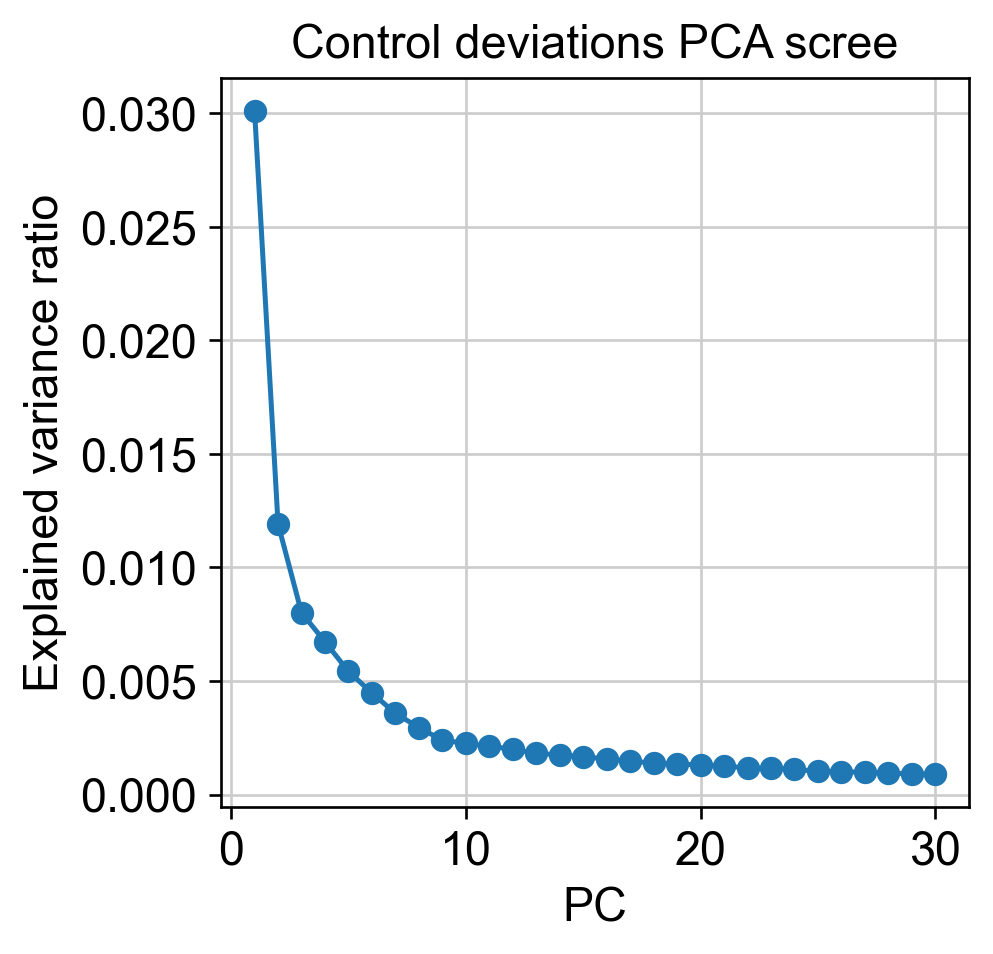

In [7]:
plt.plot(np.arange(1, N_PCS+1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('PC')
plt.ylabel('Explained variance ratio')
plt.title('Control deviations PCA scree')
plt.show()


## 4) Per-perturbation robust mean effects (Δ)

In [9]:
from scipy import sparse
import numpy as np
import pandas as pd

def _to_dense_2d(X, n_obs=None, n_vars=None):
    """Return a 2-D float64 numpy array from sparse/dense/scalar-ish inputs."""
    if sparse.issparse(X):
        X = X.toarray()
    else:
        X = np.asarray(X)
    if X.ndim == 0:            # scalar edge case
        X = X.reshape(1, 1)
    elif X.ndim == 1 and n_obs is not None and n_vars is not None:
        X = X.reshape(n_obs, n_vars)
    return X

def robust_median_per_gene(adata_subset):
    X = _to_dense_2d(adata_subset.X, adata_subset.n_obs, adata_subset.n_vars)
    return np.median(X, axis=0)

# --- controls' robust mean (median) ---
mu_ctrl = robust_median_per_gene(ad_ctrl)

# --- perturbation list ---
pertnames = (
    adata.obs[PERT_KEY].astype(str).unique().tolist()
)
pertnames = sorted([p for p in pertnames if p != CTRL_LABEL])

# --- compute Δ = median(pert) - median(control) ---
Delta = {}
for p in pertnames:
    ad_p = adata[adata.obs[PERT_KEY].astype(str).eq(p), :].copy()
    mu_p = robust_median_per_gene(ad_p)
    Delta[p] = mu_p - mu_ctrl

Delta = pd.DataFrame(Delta, index=adata.var_names)   # genes × perturbations
print("Delta shape:", Delta.shape)


Delta shape: (4000, 150)


## 5) Low-rank factorization of effects (NMF programs)

In [10]:
Dpos = np.maximum(Delta.values, 0.0)
nmf = NMF(n_components=N_PROGRAMS, init='nndsvda', random_state=RANDOM_SEED, max_iter=300)
W = nmf.fit_transform(Dpos)
C = nmf.components_.T
W_df = pd.DataFrame(W, index=Delta.index, columns=[f'prog{k+1}' for k in range(N_PROGRAMS)])
C_df = pd.DataFrame(C, index=Delta.columns, columns=W_df.columns)
W_df.head(), C_df.head()


(            prog1     prog2     prog3     prog4     prog5     prog6     prog7  \
 PLEKHN1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 ISG15    0.063085  0.032815  0.022337  0.040410  0.060942  0.026585  0.000000   
 AGRN     0.043529  0.032944  0.075856  0.004337  0.028177  0.014223  0.000000   
 MXRA8    0.107239  0.000000  0.012638  0.156003  0.240235  0.237348  0.008095   
 CCNL2    0.004355  0.067609  0.073206  0.000000  0.025885  0.069094  0.000000   
 
             prog8     prog9    prog10  
 PLEKHN1  0.000000  0.000000  0.000000  
 ISG15    0.080022  0.113457  0.000000  
 AGRN     0.003415  0.000962  0.004370  
 MXRA8    0.000000  0.054754  0.185314  
 CCNL2    0.024336  0.000000  0.003192  ,
            prog1     prog2     prog3     prog4     prog5  prog6     prog7  \
 ACAT2   0.643342  0.000000  0.000000  0.021534  0.000000    0.0  0.748124   
 ACVR1B  0.353512  0.052779  0.172973  0.000000  0.098042    0.0  0.000000   
 AKT2    0.454921  0.0000

## 6) Map baseline state → program coefficients (ridge)

In [11]:
S_ctrl_df = pd.DataFrame(S_ctrl, index=ad_ctrl.obs_names, columns=[f'PC{k+1}' for k in range(N_PCS)])
X_base = np.tile(S_ctrl_df.mean(axis=0).values, (len(C_df), 1))
ridge = Ridge(alpha=RIDGE_ALPHA)
ridge.fit(X_base, C_df.values)
B_hat = ridge.coef_
B_hat.shape


(10, 30)

## 7) Leave-one-perturbation-out (LOPO) evaluation

LOPO mean R^2: -0.12946318507194518


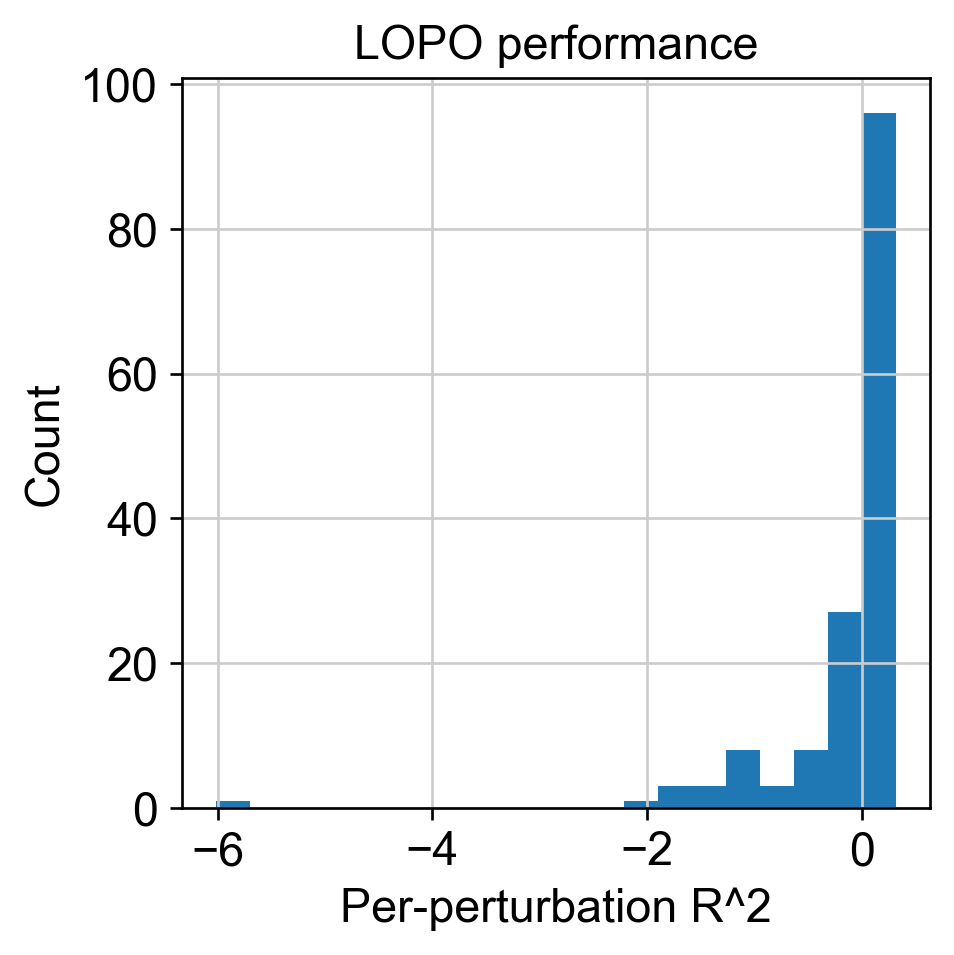

In [12]:
def lopo_eval(W, C_df, X_base, ridge_alpha=RIDGE_ALPHA):
    P, K = C_df.shape
    y_true, y_pred, r2s = [], [], []
    for i in range(P):
        X_tr = np.delete(X_base, i, axis=0)
        Y_tr = np.delete(C_df.values, i, axis=0)
        m = Ridge(alpha=ridge_alpha)
        m.fit(X_tr, Y_tr)
        c_hat = m.predict(X_base[i:i+1, :])
        delta_hat = W @ c_hat.T
        delta_true = np.maximum(Delta.values[:, [i]], 0.0)
        r2s.append(r2_score(delta_true.ravel(), delta_hat.ravel()))
    return r2s

r2s = lopo_eval(W, C_df, X_base)
print("LOPO mean R^2:", np.mean(r2s))
plt.hist(r2s, bins=20)
plt.xlabel('Per-perturbation R^2')
plt.ylabel('Count')
plt.title('LOPO performance')
plt.show()


## 8) Save artifacts

In [13]:
outdir = "vcc_modules_outputs"
os.makedirs(outdir, exist_ok=True)
W_df.to_csv(os.path.join(outdir, "W_df.csv"))
C_df.to_csv(os.path.join(outdir, "C_df.csv"))
np.save(os.path.join(outdir, "PC_loadings.npy"), PC_loadings)
np.save(os.path.join(outdir, "S_ctrl_mean.npy"), S_ctrl_df.mean(axis=0).values)
print("Saved to", outdir)


NameError: name 'os' is not defined

# enrichment in highly variable gene hetergeneity 

## 0) Setup (controls, symbols)

Make sure you’ve got the controls subset and gene symbols handy.


In [15]:
import numpy as np, pandas as pd
from scipy import sparse, stats

# controls
is_ctrl = adata.obs[PERT_KEY].astype(str).eq(CTRL_LABEL)
ad_ctrl = adata[is_ctrl, :].copy()

# get a dense view for per-gene stats (we’re on ~4k HVGs so OK)


if sparse.issparse(ad_ctrl.X):
    Xc = ad_ctrl.X.toarray()   # convert to dense NumPy array
else:
    Xc = np.asarray(ad_ctrl.X)


# gene labels
gene_names = ad_ctrl.var_names.to_numpy()


## 1) Quantify variability robustly

Use both plain variance and a robust measure (MAD-based SD). Store results in var for easy plotting.

In [17]:
# per-gene mean (log1p), variance, robust SD (MAD * 1.4826)
g_mean = Xc.mean(axis=0)
g_var  = Xc.var(axis=0)
g_mad  = stats.median_abs_deviation(Xc, axis=0, scale='normal')
g_mad[g_mad==0] = 1e-9

ad_ctrl.var['baseline_mean'] = g_mean
ad_ctrl.var['baseline_var']  = g_var
ad_ctrl.var['baseline_rsd']  = g_mad   # robust SD


In [19]:
hi_q = np.quantile(ad_ctrl.var['baseline_rsd'], 0.9)
lo_q = np.quantile(ad_ctrl.var['baseline_rsd'], 0.1)

high_var_genes = ad_ctrl.var_names[ad_ctrl.var['baseline_rsd'] >= hi_q]
low_var_genes  = ad_ctrl.var_names[ad_ctrl.var['baseline_rsd'] <= lo_q]

len(high_var_genes), len(low_var_genes)


(400, 1518)

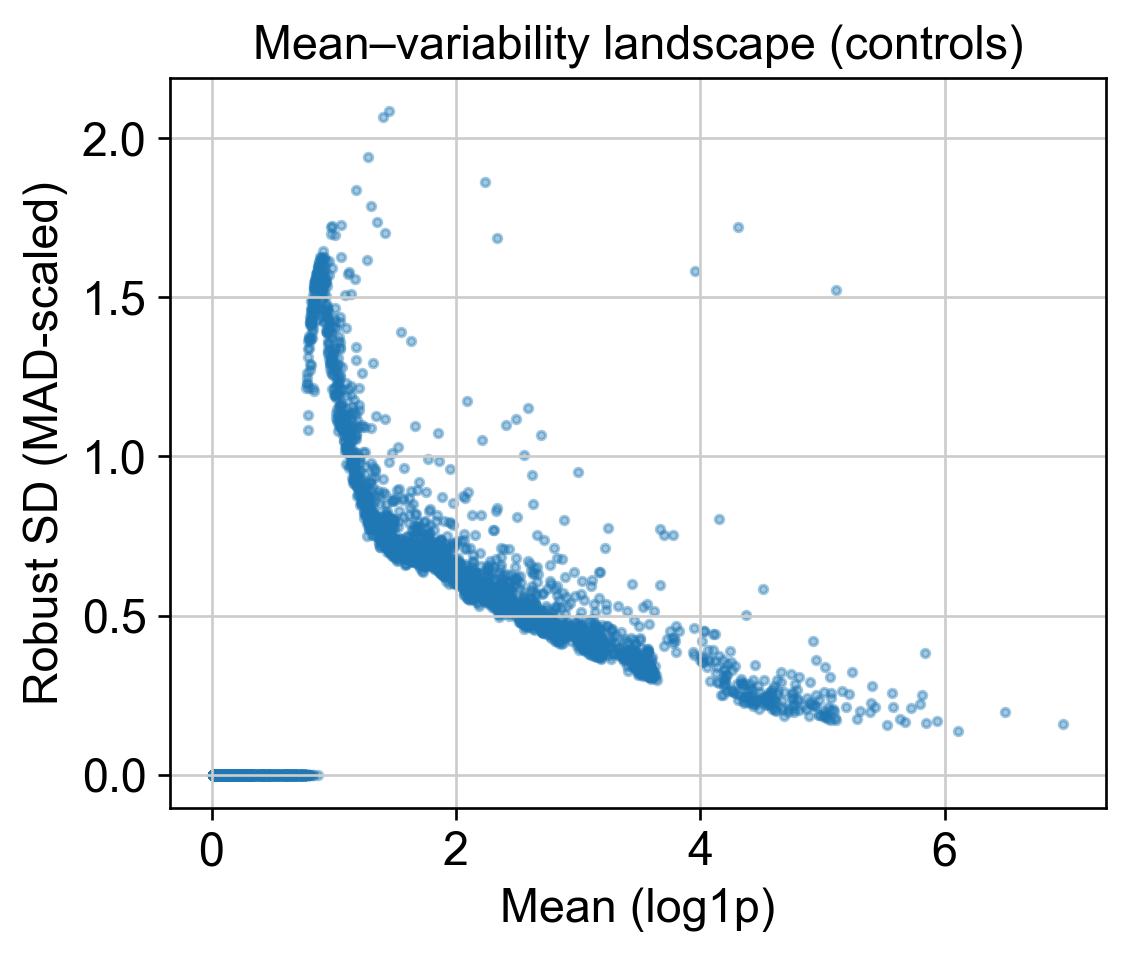

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.scatter(ad_ctrl.var['baseline_mean'], ad_ctrl.var['baseline_rsd'], s=6, alpha=0.4)
plt.xlabel('Mean (log1p)'); plt.ylabel('Robust SD (MAD-scaled)')
plt.title('Mean–variability landscape (controls)')
plt.show()


## 2) Pathway enrichment (ORA/GSEA)

The simplest path in Python is gseapy. If you have internet in that env:


In [21]:
import gseapy as gp

# choose a gene set library; common choices:
# 'Reactome_2022', 'GO_Biological_Process_2023', 'MSigDB_Hallmark_2020'
LIB = 'MSigDB_Hallmark_2020'   # small, interpretable
organism = 'Human'

# enrichment for high-variable genes (Over-Representation Analysis)
enrich_hi = gp.enrichr(gene_list=high_var_genes.tolist(),
                       gene_sets=LIB, organism=organism, cutoff=1.0, outdir=None)
enrich_lo = gp.enrichr(gene_list=low_var_genes.tolist(),
                       gene_sets=LIB, organism=organism, cutoff=1.0, outdir=None)

# show top hits

enrich_lo.results.sort_values('Adjusted P-value').head(15)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,36/200,0.000001,0.000024,0,0,2.713242,37.474034,BTG2;CDKN1A;TNFAIP6;CD80;SERPINE1;TNC;CXCL1;PT...
1,MSigDB_Hallmark_2020,Myogenesis,36/200,0.000001,0.000024,0,0,2.713242,37.474034,RYR1;MYOM1;CDKN1A;LAMA2;HSPB2;LDB3;COX6A2;COX7...
2,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,33/200,0.000019,0.000225,0,0,2.437126,26.524369,LAMA2;WIPF1;ITGB3;SERPINE1;TNC;CXCL1;RGS4;CDH6...
3,MSigDB_Hallmark_2020,KRAS Signaling Up,33/200,0.000019,0.000225,0,0,2.437126,26.524369,NRP1;SNAP25;SPON1;TPH1;PTPRR;ABCB1;CAB39L;CXCR...
4,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,32/199,0.000042,0.000372,0,0,2.361683,23.797764,CD86;ITIH5;NRP1;ABCB1;GUCY1B1;RORA;GPR83;PTH1R...
5,MSigDB_Hallmark_2020,Inflammatory Response,32/200,0.000046,0.000372,0,0,2.347497,23.419425,CDKN1A;BTG2;CALCRL;CD82;TNFAIP6;ITGB3;SERPINE1...
6,MSigDB_Hallmark_2020,Interferon Gamma Response,31/200,0.000111,0.000667,0,0,2.259038,20.568029,CD86;CDKN1A;TNFAIP6;IFIT1;PTGS2;IFIT3;MT2A;APO...
7,MSigDB_Hallmark_2020,p53 Pathway,31/200,0.000111,0.000667,0,0,2.259038,20.568029,CDKN1A;BTG2;CD82;GLS2;HSPA4L;KLK8;CDKN2AIP;DRA...
8,MSigDB_Hallmark_2020,KRAS Signaling Dn,30/200,0.000256,0.001366,0,0,2.171727,17.959052,RYR1;PRKN;CNTFR;PTGFR;RYR2;BTG2;KCNE2;THRB;CD8...
9,MSigDB_Hallmark_2020,Estrogen Response Early,29/200,0.000569,0.002732,0,0,2.085543,15.581490,CLIC3;TMPRSS3;SLC1A1;RHOBTB3;SLC1A4;THSD4;CALB...


In [23]:
enrich_hi.results.sort_values('Adjusted P-value').head(15)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,21/200,6.511144e-10,3.125349e-08,0,0,6.011719,127.161889,PPP1R15A;EGR1;JUN;SMAD3;DUSP1;PLAUR;TAP1;FOS;C...
1,MSigDB_Hallmark_2020,Hypoxia,19/200,2.235096e-08,5.364230e-07,0,0,5.350285,94.252741,PPP1R15A;SRPX;JUN;DUSP1;CAV1;PLAUR;PRKCA;PYGM;...
2,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,15/200,1.282491e-05,2.051986e-04,0,0,4.088803,46.056772,FBN2;JUN;COL16A1;NTM;ITGA2;APLP1;TFPI2;HTRA1;P...
3,MSigDB_Hallmark_2020,p53 Pathway,14/200,5.313872e-05,6.376646e-04,0,0,3.785671,37.260859,PPP1R15A;JUN;DGKA;RGS16;TAP1;ABAT;FOS;ZMAT3;DD...
4,MSigDB_Hallmark_2020,Coagulation,11/138,1.060183e-04,1.017775e-03,0,0,4.335830,39.681077,KLF7;C1S;C1R;ITGA2;HPN;TFPI2;P2RY1;HTRA1;PRSS2...
5,MSigDB_Hallmark_2020,Estrogen Response Early,13/200,2.045469e-04,1.402608e-03,0,0,3.487253,29.623212,ABCA3;HSPB8;KAZN;ABAT;FOS;PRSS23;SOX3;MLPH;MYC...
6,MSigDB_Hallmark_2020,KRAS Signaling Up,13/200,2.045469e-04,1.402608e-03,0,0,3.487253,29.623212,PPP1R15A;PEG3;ITGA2;RGS16;PLAUR;NIN;TMEM158;CA...
7,MSigDB_Hallmark_2020,UV Response Dn,10/144,6.521755e-04,3.884739e-03,0,0,3.724837,27.322416,SMAD3;FZD2;DUSP1;NFIB;MYC;CAV1;ANXA4;PRKCA;NR3...
8,MSigDB_Hallmark_2020,Estrogen Response Late,12/200,7.283886e-04,3.884739e-03,0,0,3.193463,23.071738,SOX3;CA2;ABCA3;ID2;CAV1;HSPB8;TFPI2;SNX10;FOS;...
9,MSigDB_Hallmark_2020,Apical Surface,5/44,1.784845e-03,8.567257e-03,0,0,6.348913,40.178609,SRPX;GSTM3;SCUBE1;PLAUR;SULF2


 ## 3) Functional classes: TFs, kinases, receptors, histones, etc.
### Option A — quick heuristic using gene-name patterns (fast, imperfect)

Good for a first pass if you don’t have curated lists handy.

In [24]:
genes = pd.Index(gene_names)

def tag_class(g):
    g = g.upper()
    if g.startswith('HIST') or g.startswith('H2A') or g.startswith('H2B') or g.startswith('H3') or g.startswith('H4'):
        return 'histone'
    if g.endswith('KINASE') or g.endswith('K') or g in {'PRKACA','MAPK1','AKT1','CDK1','CDK2'}:
        return 'kinase_like'
    if g.endswith('TF') or g in {'MYC','JUN','FOS','NFKB1','TP53','STAT1','STAT3','GATA3','SPI1'}:
        return 'TF_like'
    if g.startswith('GPCR') or g.endswith('R') or g.startswith('IL') and g.endswith('R'):
        return 'receptor_like'
    return 'other'

classes = genes.to_series().apply(tag_class)
ad_ctrl.var['rough_class'] = classes.values
ad_ctrl.var['is_high_var'] = ad_ctrl.var_names.isin(high_var_genes).astype(int)
ad_ctrl.var['is_low_var']  = ad_ctrl.var_names.isin(low_var_genes).astype(int)

ad_ctrl.var.groupby('rough_class')[['is_high_var','is_low_var']].mean().sort_values('is_high_var', ascending=False)


,is_high_var,is_low_var
rough_class,,
TF_like,0.600000,0.200000
histone,0.400000,0.360000
receptor_like,0.133333,0.483333
other,0.097115,0.378928
kinase_like,0.071429,0.285714


## 4) sanity checks / visuals

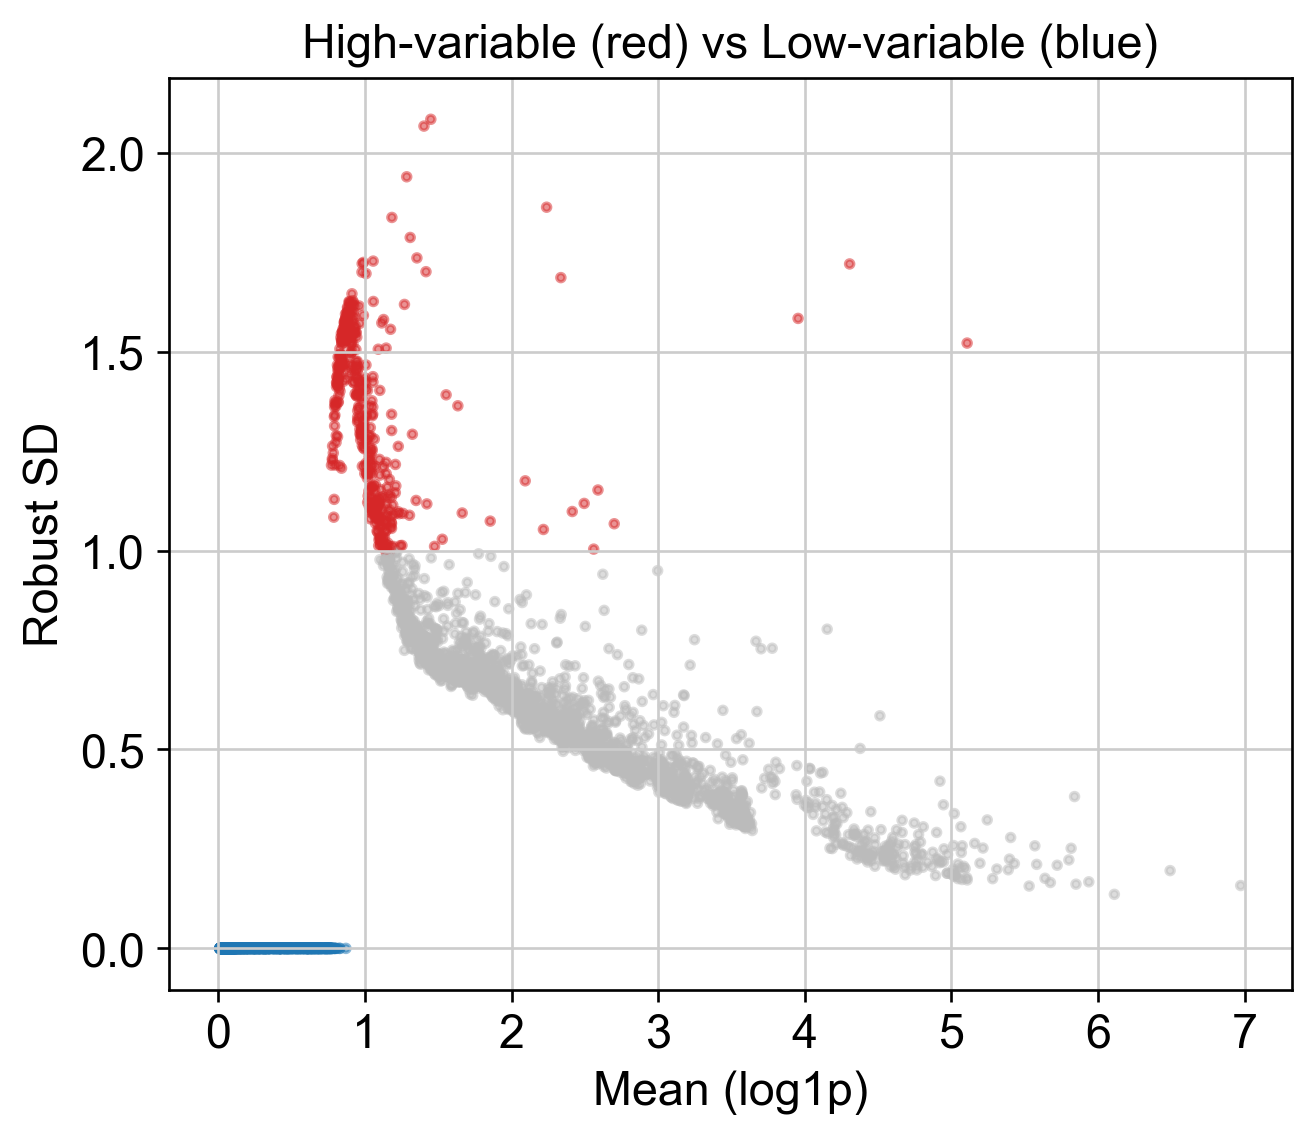

In [25]:
hv = set(high_var_genes); lv = set(low_var_genes)
col = ['#d62728' if g in hv else '#1f77b4' if g in lv else '#bbbbbb' for g in ad_ctrl.var_names]
plt.figure(figsize=(6,5))
plt.scatter(ad_ctrl.var['baseline_mean'], ad_ctrl.var['baseline_rsd'], s=6, c=col, alpha=0.5)
plt.xlabel('Mean (log1p)'); plt.ylabel('Robust SD')
plt.title('High-variable (red) vs Low-variable (blue)')
plt.show()


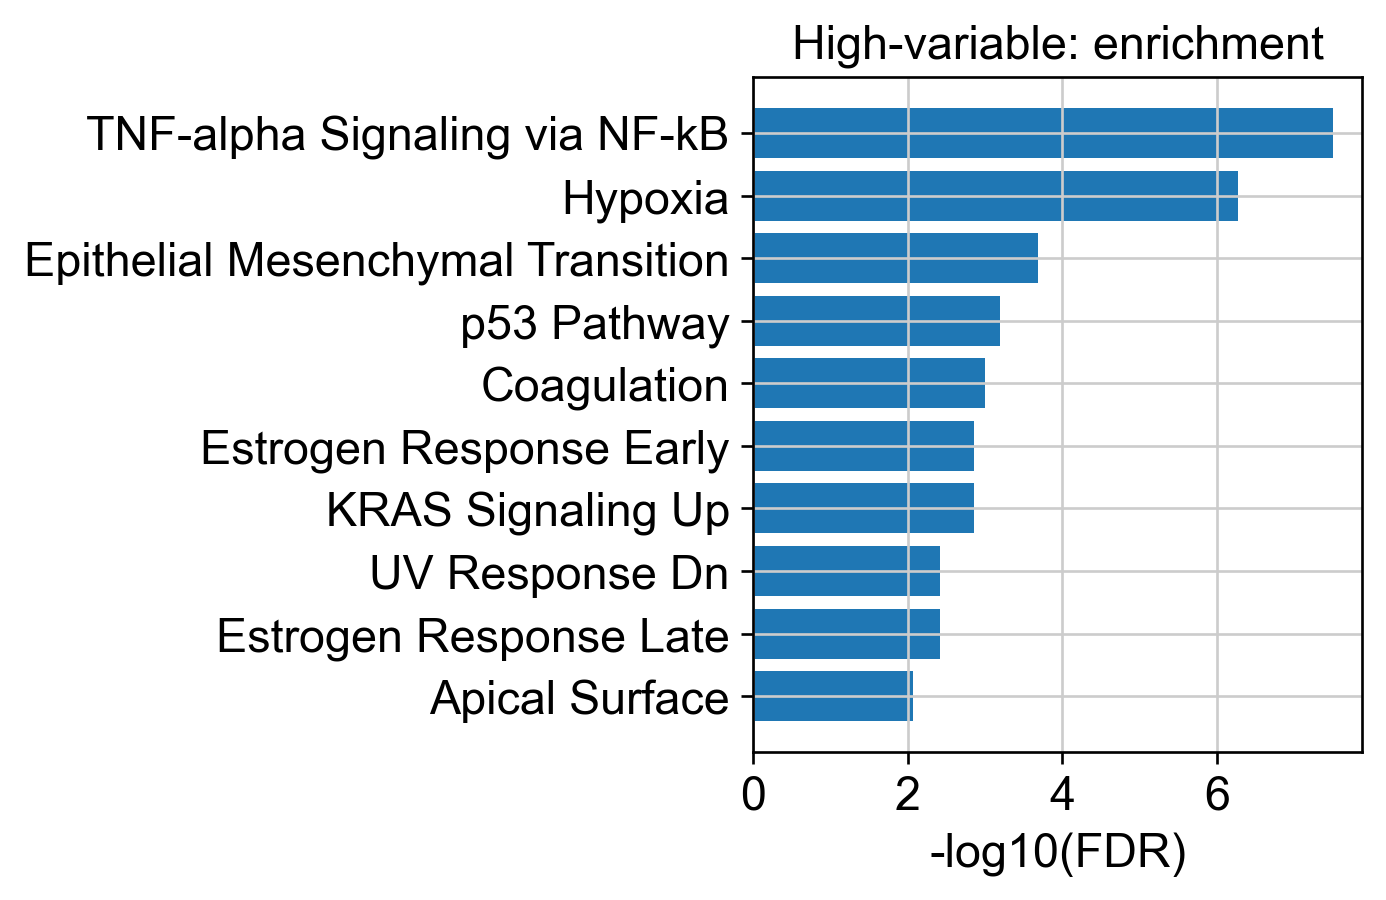

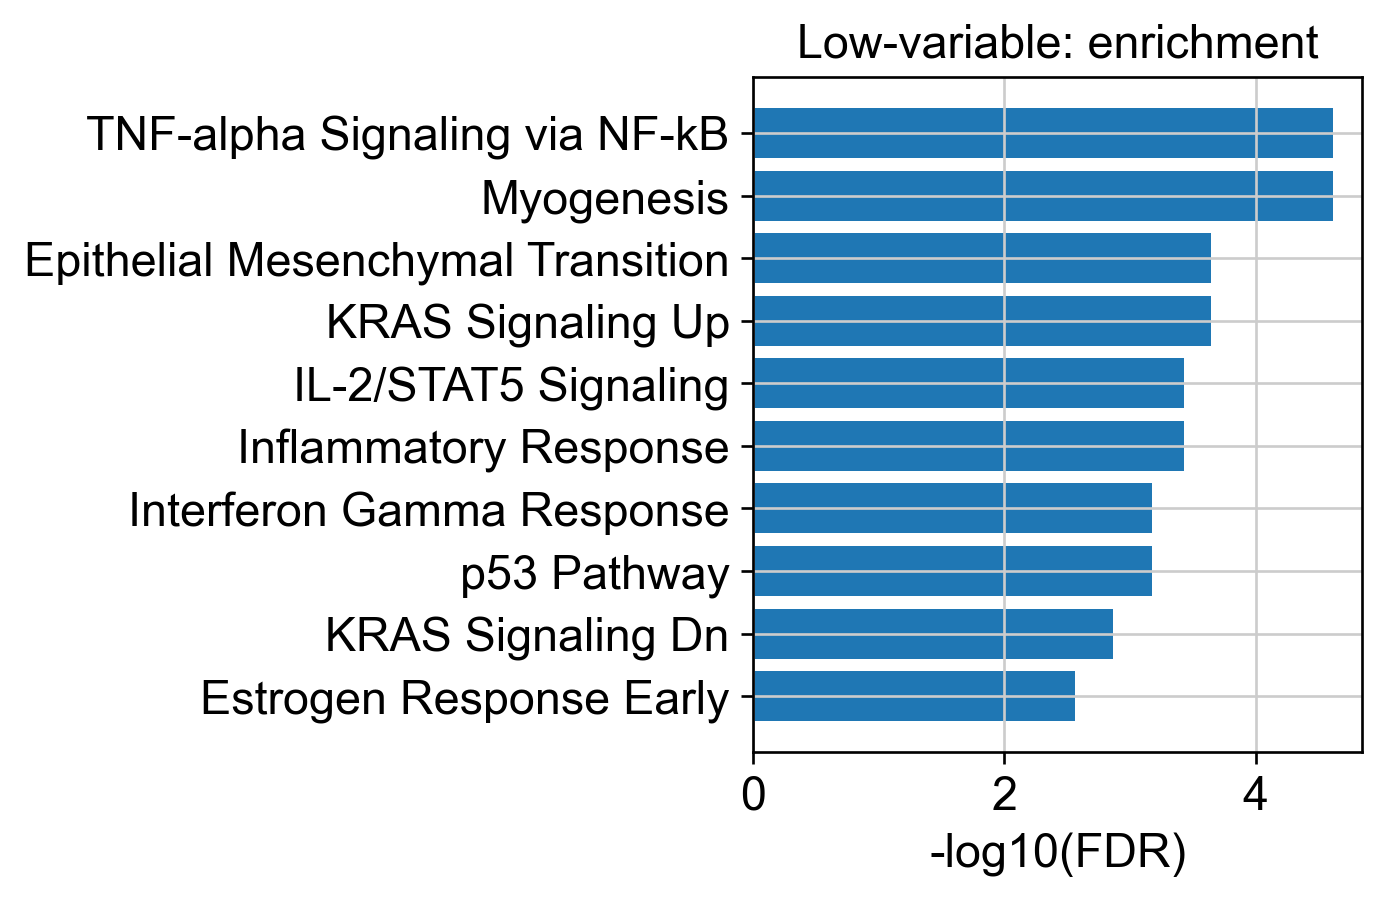

In [26]:
def bar_top(enrich_res, title, k=10):
    df = enrich_res.results.sort_values('Adjusted P-value').head(k)
    plt.figure(figsize=(6,4))
    plt.barh(df['Term'][::-1], -np.log10(df['Adjusted P-value'][::-1]))
    plt.xlabel('-log10(FDR)'); plt.title(title); plt.tight_layout(); plt.show()

bar_top(enrich_hi, 'High-variable: enrichment')
bar_top(enrich_lo, 'Low-variable: enrichment')


## Looking at the three groups
“heterogeneous regulators” vs “stable housekeeping” vs “uninformative flats.

In [37]:
# thresholds
mad_hi_q = np.quantile(ad_ctrl.var['baseline_rsd'], 0.9)
mad_lo_q = np.quantile(ad_ctrl.var['baseline_rsd'], 0.25)

# cutoffs on mean (log1p scale, tweak as needed)
low_mean_cut = 1.0
high_mean_cut = 3.0

# groups
high_var = ad_ctrl.var['baseline_rsd'] >= mad_hi_q
low_expr_low_var  = (ad_ctrl.var['baseline_mean'] < low_mean_cut)  & (ad_ctrl.var['baseline_rsd'] <= mad_lo_q)
high_expr_low_var = (ad_ctrl.var['baseline_mean'] > high_mean_cut) & (ad_ctrl.var['baseline_rsd'] <= mad_hi_q) & (ad_ctrl.var['baseline_rsd'] >= mad_lo_q)

print("High-var genes:", high_var.sum())
print("Low-expr low-var genes:", low_expr_low_var.sum())
print("High-expr low-var genes:", high_expr_low_var.sum())


High-var genes: 400
Low-expr low-var genes: 1518
High-expr low-var genes: 545


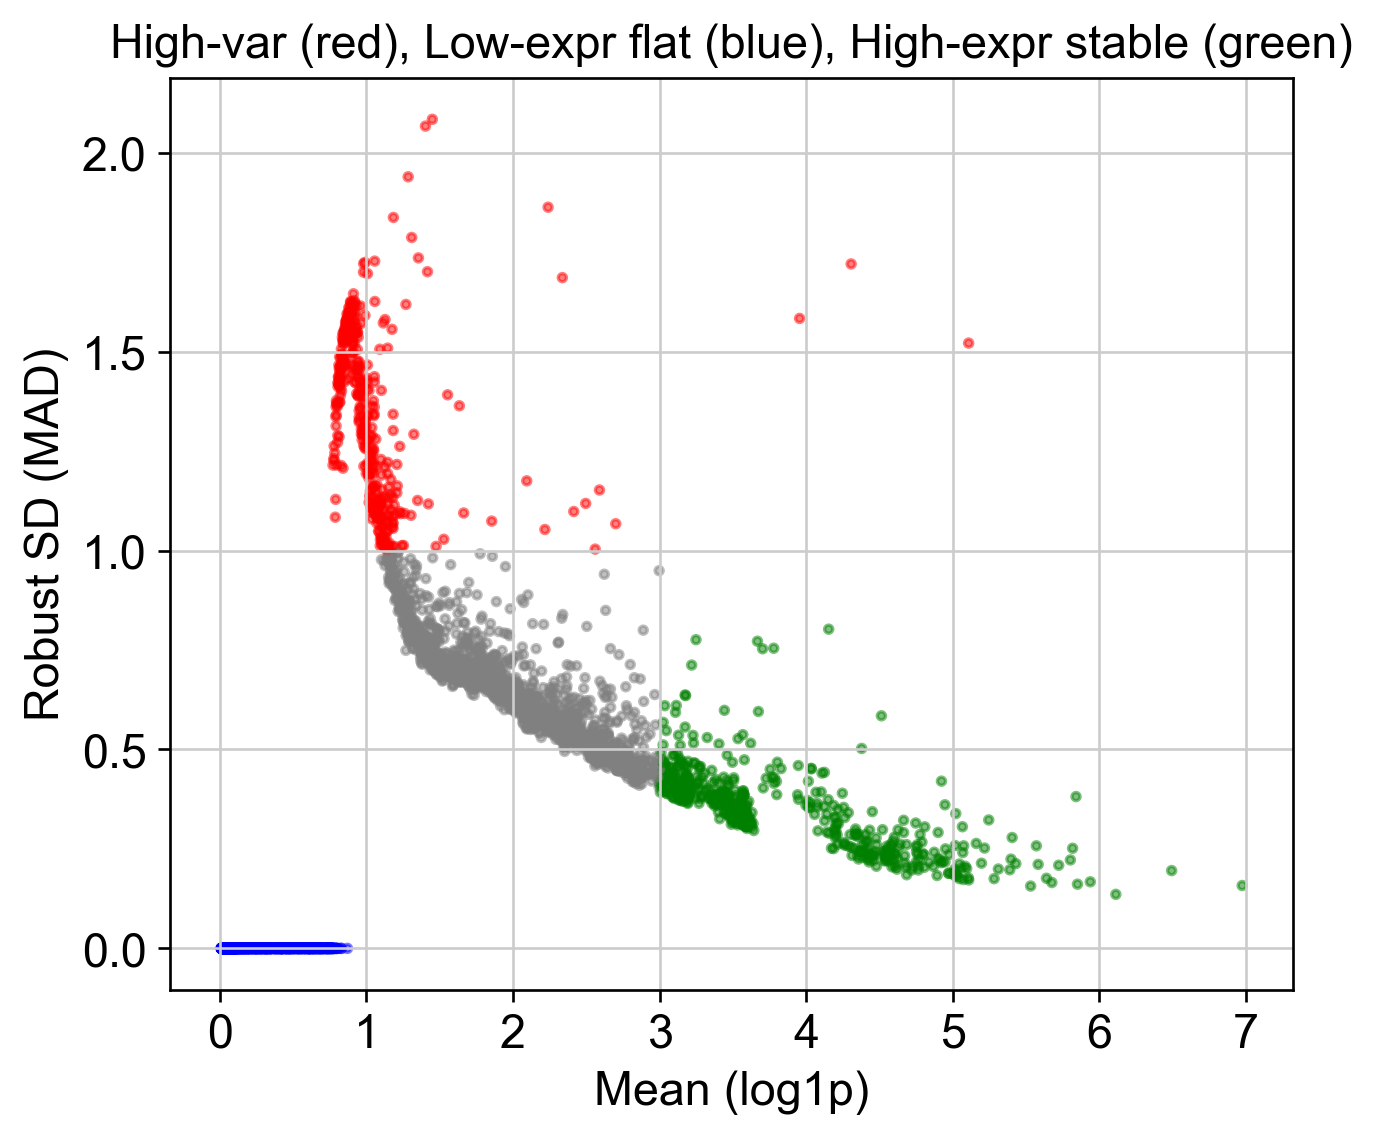

In [38]:
colors = []
for g in ad_ctrl.var_names:
    if high_var.loc[g]: colors.append('red')
    elif low_expr_low_var.loc[g]: colors.append('blue')
    elif high_expr_low_var.loc[g]: colors.append('green')
    else: colors.append('grey')

plt.figure(figsize=(6,5))
plt.scatter(ad_ctrl.var['baseline_mean'], ad_ctrl.var['baseline_rsd'], s=6, c=colors, alpha=0.5)
plt.xlabel('Mean (log1p)')
plt.ylabel('Robust SD (MAD)')
plt.title('High-var (red), Low-expr flat (blue), High-expr stable (green)')
plt.show()



## Enrichment

Counts: 400 (high-var), 1518 (low-expr low-var), 545 (high-expr low-var)


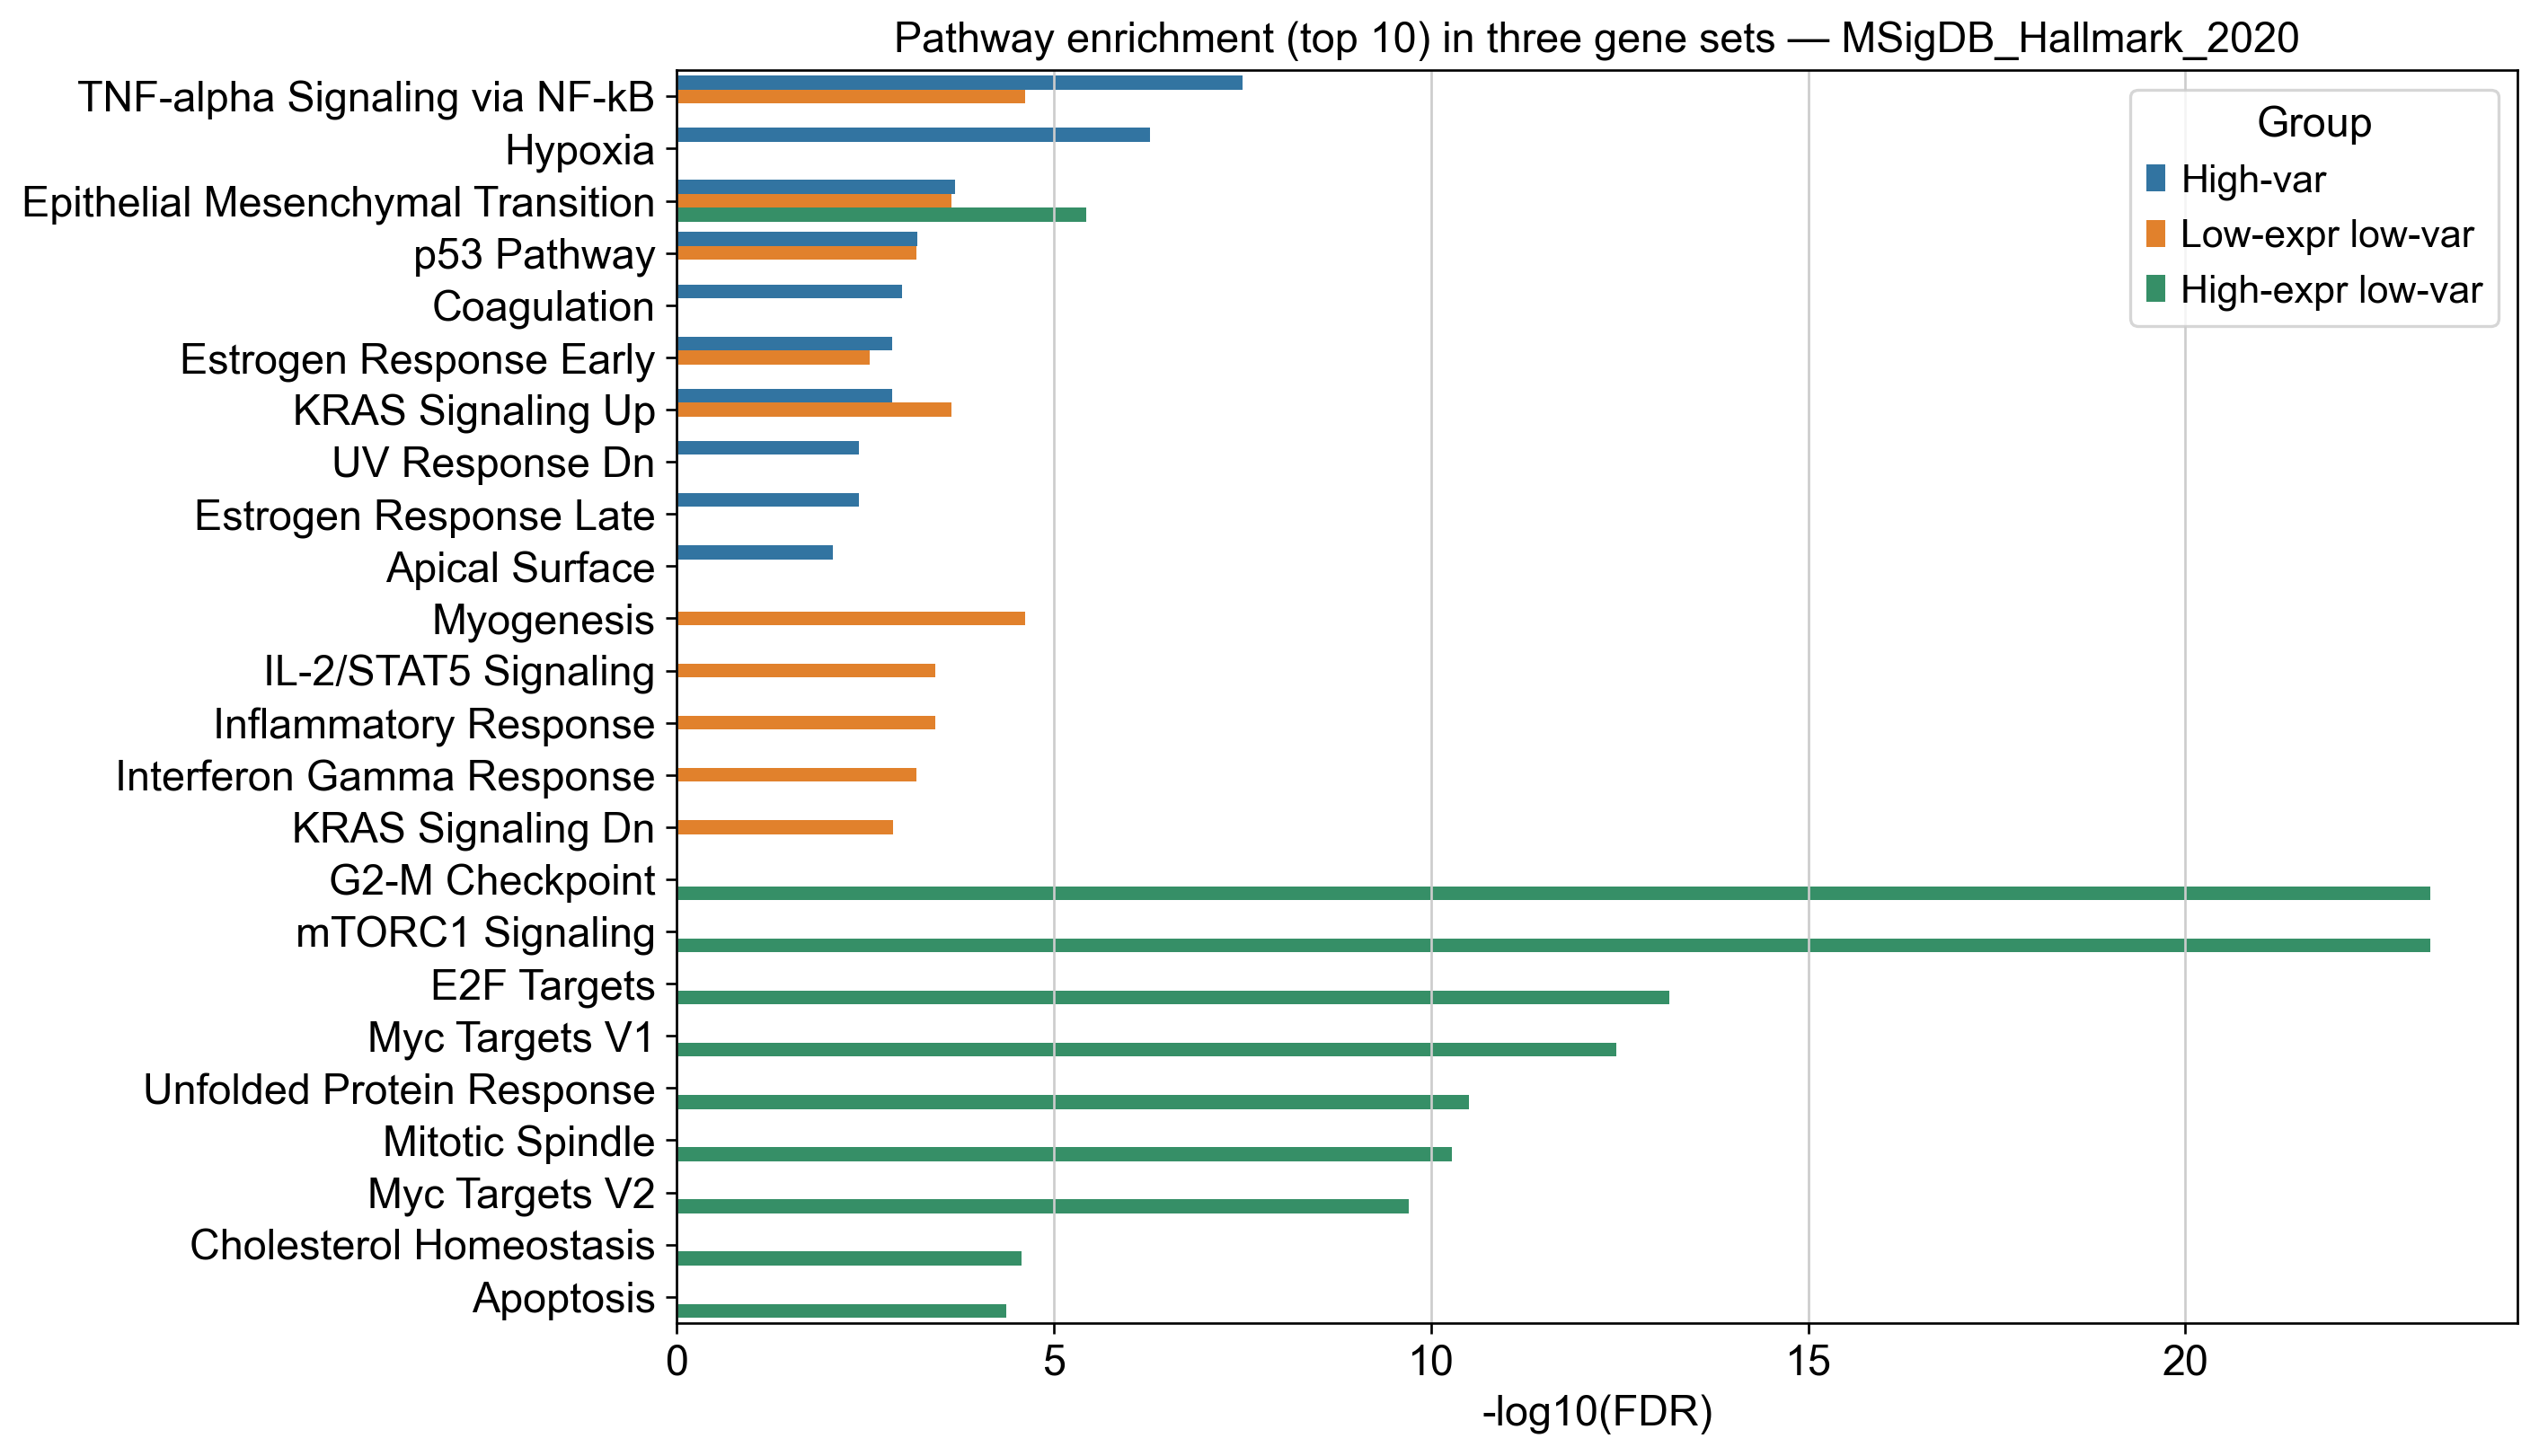

In [40]:
import gseapy as gp

import numpy as np, pandas as pd
import gseapy as gp
import seaborn as sns
import matplotlib.pyplot as plt

LIB = 'MSigDB_Hallmark_2020'   # or 'GO_Biological_Process_2023', etc.
organism = 'Human'
TOPK = 10

def run_enrich_df(genes, group_label):
    genes = list(pd.Index(genes).dropna().astype(str))
    if len(genes) == 0:
        return pd.DataFrame(columns=["Term","Adjusted P-value","Group","neglog10"])
    res = gp.enrichr(gene_list=genes, gene_sets=LIB, organism=organism, outdir=None)
    df = res.results.copy()
    if df.empty:
        return pd.DataFrame(columns=["Term","Adjusted P-value","Group","neglog10"])
    df = df.sort_values("Adjusted P-value").head(TOPK)
    # guard against zero p-values for -log10
    df["neglog10"] = -np.log10(np.clip(df["Adjusted P-value"].astype(float), 1e-300, None))
    df["Group"] = group_label
    return df[["Term","Adjusted P-value","neglog10","Group"]]

# Build the three gene sets (you already defined these booleans above)
genes_highvar  = ad_ctrl.var_names[high_var]
genes_lowflat  = ad_ctrl.var_names[low_expr_low_var]
genes_highstable = ad_ctrl.var_names[high_expr_low_var]

print("Counts:",
      len(genes_highvar), "(high-var),",
      len(genes_lowflat), "(low-expr low-var),",
      len(genes_highstable), "(high-expr low-var)")

df_hi  = run_enrich_df(genes_highvar,    "High-var")
df_loE = run_enrich_df(genes_lowflat,    "Low-expr low-var")
df_hiE = run_enrich_df(genes_highstable, "High-expr low-var")

results_all = pd.concat([df_hi, df_loE, df_hiE], ignore_index=True)
if results_all.empty:
    print("No enrichment results returned. Try a different library or thresholds.")
else:
    # order terms within each group by significance
    results_all["Term"] = results_all["Term"].astype(str)
    # plot
    plt.figure(figsize=(12, 7))
    sns.barplot(
        data=results_all,
        y="Term", x="neglog10", hue="Group",
        orient="h", dodge=True
    )
    plt.xlabel("-log10(FDR)")
    plt.ylabel("")
    plt.title(f"Pathway enrichment (top {TOPK}) in three gene sets — {LIB}")
    plt.tight_layout()
    plt.show()



## 🔹 Step 2. Compute perturbation effects

For each perturbation 
𝑝
p:

Subset to cells with obs['target_gene'] == p and controls.

Compute per-gene mean logFC (log fold-change vs. controls).

In [41]:
def perturb_effect(adata, pert, ctrl_label="non-targeting"):
    pert_cells = adata[adata.obs['target_gene'] == pert, :].X
    ctrl_cells = adata[adata.obs['target_gene'] == ctrl_label, :].X
    pert_cells = pert_cells.A if hasattr(pert_cells, 'A') else pert_cells
    ctrl_cells = ctrl_cells.A if hasattr(ctrl_cells, 'A') else ctrl_cells
    mean_fc = np.log1p(pert_cells.mean(axis=0)) - np.log1p(ctrl_cells.mean(axis=0))
    return np.asarray(mean_fc).ravel()


## 🔹 Step 3. Summarize per-regime effects

For each perturbation, average the absolute effect sizes within each regime:

In [42]:
effects = {}
for pert in pertnames:   # list of perturbation labels
    fc = perturb_effect(adata, pert)
    effects[pert] = {
        "High-var": np.mean(np.abs(fc[high_var])),
        "Low-expr low-var": np.mean(np.abs(fc[low_expr_low_var])),
        "High-expr low-var": np.mean(np.abs(fc[high_expr_low_var]))
    }

effects_df = pd.DataFrame.from_dict(effects, orient="index")


## Step 4. Compare regimes

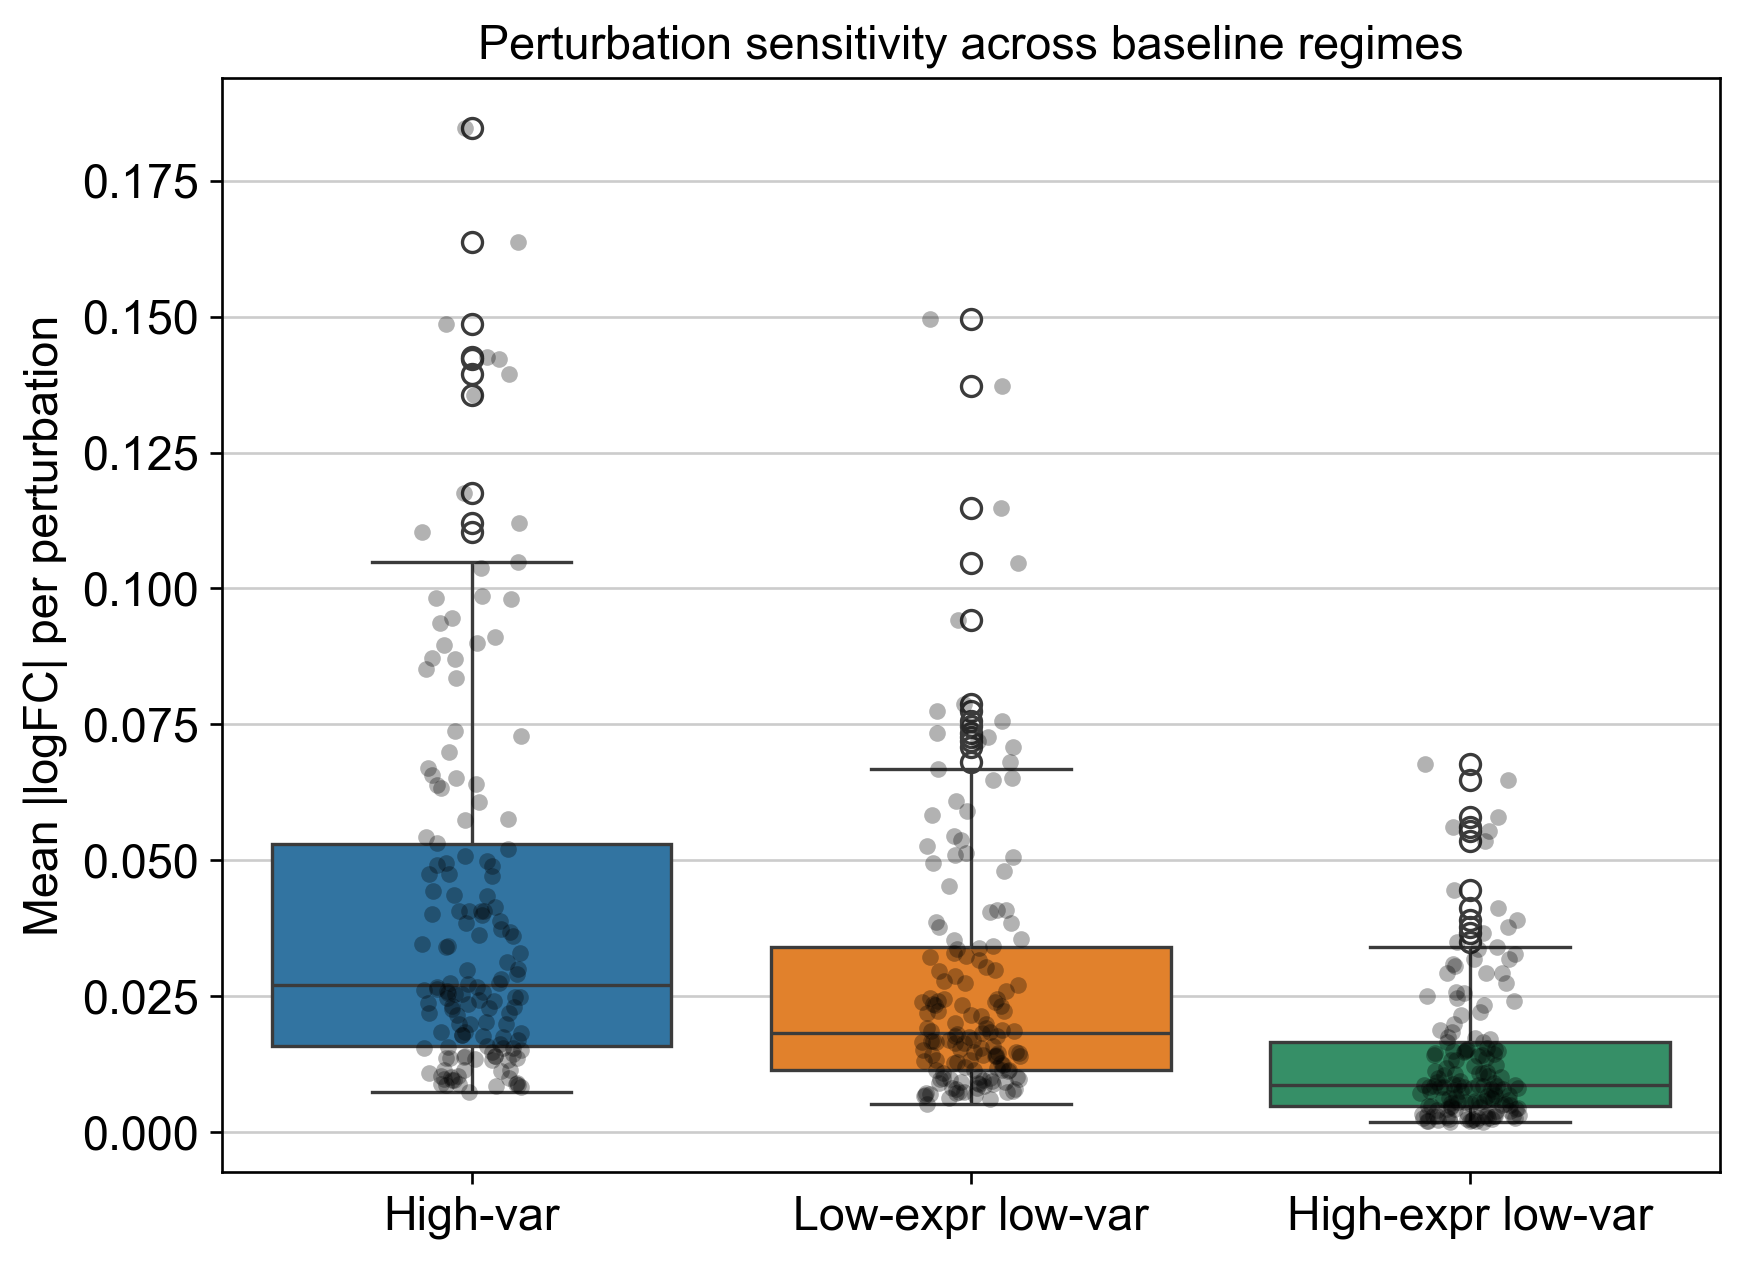

In [43]:
plt.figure(figsize=(8,6))
sns.boxplot(data=effects_df)
sns.stripplot(data=effects_df, color="k", alpha=0.3)
plt.ylabel("Mean |logFC| per perturbation")
plt.title("Perturbation sensitivity across baseline regimes")
plt.show()
